# Imports

In [1]:
import tensorflow as tf

In [2]:
import os
import tensorflow as tf
import numpy as np
import six.moves.urllib as urllib
import pathlib
import requests
import re
import sys
import tarfile
import zipfile
import cv2
import pandas as pd
import time

from datetime import date
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

Import the object detection module.

In [3]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Patches:

In [4]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [5]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = './Tensorflow/workspace/annotations/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index)

{1: {'id': 1, 'name': 'Bruised broken wing (FP09)'}, 2: {'id': 2, 'name': 'Bruised broken leg (FP10)'}, 3: {'id': 3, 'name': 'Bruised breast (FP11)'}, 4: {'id': 4, 'name': 'Bruised back (FP16)'}, 5: {'id': 5, 'name': 'Bruised neck (FP22)'}, 6: {'id': 6, 'name': 'Bruised elbow (FP32)'}, 7: {'id': 7, 'name': 'Whole duck'}}


For the sake of simplicity we will test on 2 images:

In [6]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('./Tensorflow/workspace/images/test/')
# PATH_TO_TEST_IMAGES_DIR = pathlib.Path('D:/files/datasets/bruiseduck/images/test')
# TEST_IMAGE_PATHS

# Detection

Load an object detection model:

In [7]:
# detection_model = tf.saved_model.load('Tensorflow/workspace/models/my_ssd_resnet50_v1_fpn/exportv2/saved_model')
detection_model = tf.saved_model.load('Tensorflow/workspace/models/my_ssd_mobilenet_v2_fpnlite/exportv9/saved_model')
# detection_model = tf.saved_model.load('Tensorflow/workspace/models/my_faster_rcnn_resnet50_v1/exportv2/saved_model')

Check the model's input signature, it expects a batch of 3-color images of type uint8:

In [7]:
# print(detection_model.signatures['serving_default'].inputs)

And returns several outputs:

In [9]:
detection_model.signatures['serving_default'].output_dtypes

{'num_detections': tf.float32,
 'detection_classes': tf.float32,
 'raw_detection_scores': tf.float32,
 'detection_scores': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'raw_detection_boxes': tf.float32,
 'detection_boxes': tf.float32,
 'detection_anchor_indices': tf.float32}

In [10]:
detection_model.signatures['serving_default'].output_shapes

{'num_detections': TensorShape([1]),
 'detection_classes': TensorShape([1, 100]),
 'raw_detection_scores': TensorShape([1, 12804, 8]),
 'detection_scores': TensorShape([1, 100]),
 'detection_multiclass_scores': TensorShape([1, 100, 8]),
 'raw_detection_boxes': TensorShape([1, 12804, 4]),
 'detection_boxes': TensorShape([1, 100, 4]),
 'detection_anchor_indices': TensorShape([1, 100])}

Add a wrapper function to call the model, and cleanup the outputs:

In [8]:
def show_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(output_dict['detection_masks'], output_dict['detection_boxes'], image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [9]:
def show_inference_for_multi_image(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = show_inference_for_single_image(model, image_np)

  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=2)

  display(Image.fromarray(image_np))

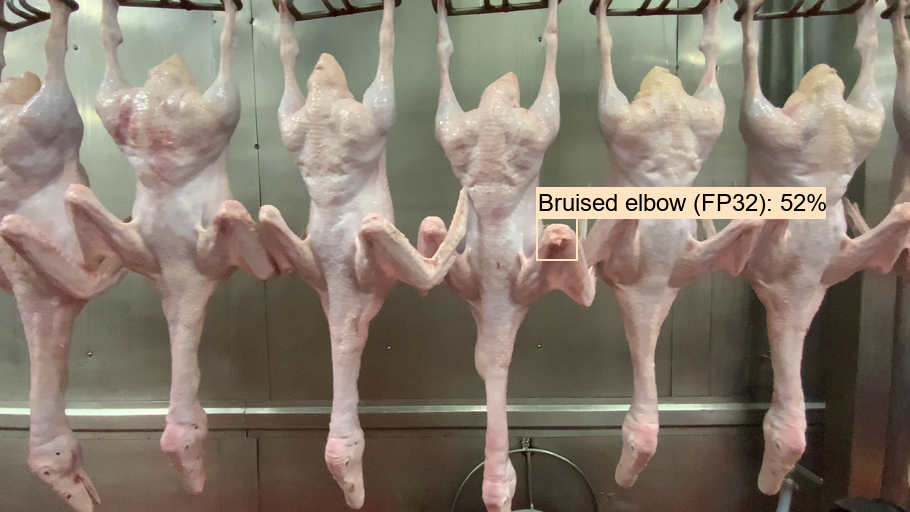

In [22]:
show_inference_for_multi_image(detection_model, "../datasets/bruiseduck/images/test/IMG_5017_01.png")

Run it on each test image and show the results:

In [10]:
def show_inference(model, image_np):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  # Actual detection.
  output_dict = show_inference_for_single_image(model, image_np)

  # Visualization of the results of a detection.
  final_img = vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks_reframed', None),
          use_normalized_coordinates=True,
          line_thickness=8)
          
  return(final_img)

In [11]:
def show_inferencev2(model, image_np, min_score_thresh = 0.5):
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    # Actual detection.
    output_dict = show_inference_for_single_image(model, image_np)

    # Visualization of the results of a detection
    # min_score_thresh = 0.8
    final_img = vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        min_score_thresh=min_score_thresh,
        line_thickness=8)

    datenow = date.today().strftime("%Y-%m-%d")
    truckno = 1
    qty = 1
    for index, line in enumerate(output_dict['detection_classes']):
        if output_dict['detection_scores'][index] > min_score_thresh:
            # print(category_index.get(line))
            name = category_index.get(line)["name"]
            code = re.findall("[F][P][0-9][0-9]",name)[0]

            response = requests.post('http://localhost:3001/api/v2/back', json={"date": datenow, "truckno": truckno, "itemcode": code, "qty" : qty})
            print("Status code: ", response.status_code, response.json())

    return(final_img)

Detect object from image:

In [12]:
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('Tensorflow/workspace/images/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.png")))
TEST_IMAGE_PATHS[0:5]

[WindowsPath('Tensorflow/workspace/images/test_images/IMG_0116_01.png'),
 WindowsPath('Tensorflow/workspace/images/test_images/IMG_0116_02.png'),
 WindowsPath('Tensorflow/workspace/images/test_images/IMG_0116_03.png'),
 WindowsPath('Tensorflow/workspace/images/test_images/IMG_0116_04.png'),
 WindowsPath('Tensorflow/workspace/images/test_images/IMG_0256.png')]

In [ ]:
for image_path in TEST_IMAGE_PATHS[0:7]:
  print(image_path)    
  show_inference_for_multi_image(detection_model, image_path)

Detect object from video:

In [12]:
def rescaleFrame(frame, scale=0.7):
    #  Images, Video and Live Video
    width = int(frame.shape[1] * scale)
    height = int(frame.shape[0] * scale)
    dimensions = (width, height)

    return cv2.resize(frame, dimensions, interpolation=cv2.INTER_AREA)

In [12]:
def show_inferencev3(model, image_np, min_score_thresh = 0.5):
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    # Actual detection.
    output_dict = show_inference_for_single_image(model, image_np)

    # Find whole duck class
    index_classes = np.where(output_dict['detection_classes'] == 7)

    for index, line in enumerate(list(index_classes[0])):
        # print(index, line)
        if(output_dict["detection_scores"][line] >= 0.3).any():
            # print(output_dict["detection_scores"][line])
            output_dict["detection_scores"][line] = np.array([0.99])

    # Visualization of the results of a detection
    # min_score_thresh = 0.8
    final_img = vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        min_score_thresh=min_score_thresh,
        line_thickness=2)

    datenow = date.today().strftime("%Y-%m-%d")
    truckno = 1
    qty = 1
    score = 0
    code = ""
    box = [0, 0, 0, 0 ]
    for index, line in enumerate(output_dict['detection_classes']):
        if output_dict['detection_scores'][index] > min_score_thresh:
            # print(str(category_index.get(line)["name"]) + " " + str(output_dict['detection_scores'][index]) + " " + str(output_dict['detection_boxes'][index]))
            name = category_index.get(line)["name"]

            if category_index.get(line)["name"] == "Whole duck":
                # print(str(category_index.get(line)["name"]) + " " + str(output_dict['detection_scores'][index]) + " " + str(output_dict['detection_boxes'][index]))
                box = output_dict['detection_boxes'][index]
            else:
                code = re.findall("[F][P][0-9][0-9]",name)[0]
                score = round(output_dict['detection_scores'][index] * 100, 2)
            
            # response = requests.post('http://192.200.9.215:8888/api/v2/back', json={"date": datenow, "truckno": truckno, "itemcode": code, "qty" : qty})
            # print("Status code: ", response.status_code, response.json())

    return(final_img, code, score, box)

In [17]:
# capture = cv2.VideoCapture("../datasets/bruiseduck/videos/Front_01.MOV") 
capture = cv2.VideoCapture("../datasets/bruiseduck/videos/Back_04.mp4") 
# capture = cv2.VideoCapture('tensorflow/workspace/videos/Front_25.mp4')
# capture = cv2.VideoCapture('tensorflow/workspace/videos/Back_25.mp4')

# Exit if video not opened.
if not capture.isOpened():
  print("Could not open video")
  sys.exit()

# Read first frame.
ok, frame = capture.read()
if not ok:
  print ('Cannot read video file')
  sys.exit()

# df_detect = pd.DataFrame()
df = pd.DataFrame()
df_detect = pd.DataFrame({'counter': [], 'code':[]})
check = True
count = 0; checkcount = 0
countFP09 = 0; countFP10 = 0; countFP11 = 0; countFP16 = 0; countFP22 = 0; countFP32 = 0

global fps, prev_frame_time, new_frame_time
fps = 0
prev_frame_time = 0
new_frame_time = 0

# We need to set resolutions.
# so, convert them from float to integer.
frame_width = int(capture.get(3))
frame_height = int(capture.get(4))
   
size = (frame_width, frame_height)
print(size )

# Below VideoWriter object will create
# a frame of above defined The output 
# is stored in 'filename.avi' file.
result = cv2.VideoWriter('bruiseduck.avi',  cv2.VideoWriter_fourcc(*'MJPG'), 24, size)

while True:
    # font which we will be using to display FPS
    wW = 7; hH = 25
    font = cv2.FONT_HERSHEY_SIMPLEX

    # Calculate FPS
    new_frame_time = time.time()
    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time

    text = 'FPS: '+str(int(fps))

  
    ok, frame = capture.read()
    # frame = rescaleFrame(frame, scale=1)
    # frame = cv2.resize(frame, (640, 480))
    (h, w, c) = frame.shape[:3]
    # print(h, w, c) 

    xW1 = int(w * (1.2/4))    
    xW2 = int(w * (2.8/4)) 
    xW3 = int(w * (2/4))
    # xW4 = int(w * (2.2/4))

    # Convert color
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

    # Rectangle
    frame = cv2.rectangle(frame, (0, 0), (xW1, h), (0, 0, 0), thickness=-1)
    frame = cv2.rectangle(frame, (xW2, 0), (w, h), (0, 0, 0), thickness=-1)
    # frame = cv2.rectangle(frame, (xW1, 0), (xW2, h), (0, 255, 0), thickness=2)

    # Blur
    # frame = cv2.bilateralFilter(frame, 15, 20, 15)

    # Crop
    # frame = frame[0: h,xW1: xW2]

    # Predict
    frame, code, score, box = show_inferencev3(detection_model,frame,min_score_thresh = 0.5)

    # Line
    cv2.line(frame, (xW3, 0),(xW3, h),(100, 255, 255))

    # Get bounding box from prediction output
    ymin, xmin, ymax, xmax = box
    (left, right, top, bottom) = (xmin * w, xmax * w, ymin * h, ymax * h)
    # print(left, right, top, bottom)
   
    p1 = (int(left), int(right))
    p2 = (int(top), int(bottom))

    # Draw the bounding box
    bX,bY = p1
    bW,bH = p2

    # Draw circle in the center of the bounding box
    bX1 = bX + int(bX/2)
    bY1 = bY + int(bY/2)
    
    bX2 = int((bX + bY) / 2)
    bY2 = int((bW + bH) / 2)

    if sum(box) > 0:
      # frame = cv2.rectangle(frame, (int(left), int(top)), (int(right), int(bottom)), (0, 0, 255))
      cv2.circle(frame, (bX2, bY2), 1, (255, 0 ,0), 2)

      if (bX2 > xW3):
        if(check):
            count += 1
            check = False
      else:
        check = True


    if (code == "FP09" or code == "FP10" or code == "FP11" or code == "FP16" or code == "FP22" or code == "FP32"):
      
      if(len(df_detect) > 0):
        listText = [[str(count),str(code)]]
        listText = [tuple(i) for i in listText]
        checkDuplicate = df_detect[df_detect[['counter', 'code']].apply(tuple, axis = 1).isin(listText)]

        if(len(checkDuplicate) == 0):
          print("counter: ", count, "code: ", code, "score: ", score)
          df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)

      else:
          print("counter: ", count, "code: ", code, "score: ", score)  
          df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)

    # Display FPS on frame
    cv2.putText(frame, text, (wW, hH * 2), font, 0.75, (50, 170, 50), 2)

    # Display Counter
    cv2.putText(frame, "Counter: " + str(count), (wW, hH * 3), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);

    # Print the centroid coordinates (we'll use the center of the bounding box) on the image
    center = "x: " + str(bX2) + ", y: " + str(bY2)
    # cv2.putText(frame, center, (bX2 - 10, bY2 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    cv2.putText(frame, str(center), (wW, hH * 4), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);
    # cv2.putText(frame, str(xW3), (wW, hH * 5), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);

    # Line
    cv2.line(frame, (xW3, 0),(xW3, h),(255, 0 ,0))
    # cv2.line(frame, (xW4, 0),(xW4, h),(255, 0 ,0))

    frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)

    # Write the frame into the
    # file 'filename.avi'
    result.write(frame)

    cv2.imshow('Bruise Duck',frame)    
    # if cv2.waitKey(1) & 0xFF==ord("q"):
    if ((0xFF & cv2.waitKey(10)) == ord('q')):
        break

capture.release()
result.release()
cv2.destroyAllWindows()

(1280, 720)
counter:  0 code:  FP16 score:  92.68


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  1 code:  FP16 score:  97.09


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  2 code:  FP16 score:  67.17


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  3 code:  FP10 score:  56.83


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  3 code:  FP16 score:  62.44


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  4 code:  FP10 score:  54.28


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  4 code:  FP09 score:  67.9


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  5 code:  FP09 score:  67.15
counter:  5 code:  FP10 score:  80.91


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)
C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  5 code:  FP16 score:  88.8


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  6 code:  FP16 score:  96.02


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  6 code:  FP09 score:  96.43


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  7 code:  FP09 score:  59.88


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  7 code:  FP16 score:  64.86


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  8 code:  FP32 score:  60.58


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  8 code:  FP16 score:  93.33


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  9 code:  FP16 score:  78.47


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  9 code:  FP10 score:  65.29


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  10 code:  FP16 score:  55.15


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  10 code:  FP32 score:  50.77


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  10 code:  FP10 score:  62.69


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  11 code:  FP10 score:  72.65


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  11 code:  FP09 score:  70.97


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  11 code:  FP32 score:  52.21


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  12 code:  FP10 score:  52.3


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  13 code:  FP10 score:  84.93


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  14 code:  FP10 score:  67.37


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  15 code:  FP16 score:  52.71


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  15 code:  FP10 score:  53.09


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  16 code:  FP16 score:  78.66


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  16 code:  FP10 score:  61.34


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  16 code:  FP32 score:  59.82


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  17 code:  FP16 score:  90.72
counter:  17 code:  FP10 score:  52.61


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)
C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  18 code:  FP10 score:  59.74


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  18 code:  FP16 score:  51.38


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  19 code:  FP10 score:  61.22
counter:  19 code:  FP16 score:  77.78


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)
C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  20 code:  FP10 score:  84.04


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  20 code:  FP16 score:  52.75


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  21 code:  FP16 score:  54.14


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  21 code:  FP10 score:  54.53
counter:  22 code:  FP10 score:  57.52


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)
C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  22 code:  FP16 score:  55.85


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  23 code:  FP16 score:  56.39


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  23 code:  FP32 score:  53.34


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  24 code:  FP32 score:  51.77


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  25 code:  FP16 score:  55.07


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  27 code:  FP16 score:  69.55


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  29 code:  FP16 score:  56.24


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  30 code:  FP16 score:  96.69


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  31 code:  FP16 score:  66.87


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  33 code:  FP10 score:  59.2


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  34 code:  FP10 score:  63.47


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  36 code:  FP32 score:  50.74


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  36 code:  FP16 score:  68.51


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  38 code:  FP10 score:  51.78


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  39 code:  FP10 score:  50.66


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  40 code:  FP10 score:  63.65


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  41 code:  FP16 score:  74.02


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  42 code:  FP16 score:  85.74


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  45 code:  FP16 score:  50.36


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  46 code:  FP16 score:  57.07


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  46 code:  FP10 score:  57.02


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  47 code:  FP10 score:  72.18


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  48 code:  FP10 score:  55.95


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  49 code:  FP10 score:  51.47


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  49 code:  FP16 score:  61.6


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  50 code:  FP16 score:  52.09


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  51 code:  FP16 score:  96.0


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  52 code:  FP16 score:  67.08


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  54 code:  FP09 score:  57.31


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  54 code:  FP10 score:  54.3


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  55 code:  FP10 score:  72.73


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  55 code:  FP09 score:  92.96


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  57 code:  FP16 score:  69.57


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  59 code:  FP16 score:  65.44


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  60 code:  FP16 score:  83.73


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  61 code:  FP16 score:  60.93


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  63 code:  FP32 score:  51.95


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  63 code:  FP16 score:  64.72


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  63 code:  FP10 score:  50.88


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  64 code:  FP16 score:  84.63


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  65 code:  FP16 score:  53.94


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  65 code:  FP32 score:  50.44


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  65 code:  FP10 score:  50.29


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  66 code:  FP16 score:  88.14


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  66 code:  FP10 score:  56.16


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  67 code:  FP16 score:  53.11


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  69 code:  FP16 score:  55.49


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  69 code:  FP32 score:  62.1


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  70 code:  FP32 score:  50.72


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  70 code:  FP16 score:  99.12


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  72 code:  FP16 score:  66.32


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  72 code:  FP22 score:  51.93


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  73 code:  FP16 score:  69.72


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  74 code:  FP32 score:  54.07


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  76 code:  FP10 score:  73.57


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  77 code:  FP10 score:  58.13


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  79 code:  FP16 score:  50.65


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  80 code:  FP16 score:  67.68


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  81 code:  FP10 score:  56.07


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  82 code:  FP16 score:  55.96


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  83 code:  FP16 score:  94.95


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  84 code:  FP16 score:  76.58


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  85 code:  FP16 score:  92.58


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  85 code:  FP32 score:  53.35


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  87 code:  FP16 score:  53.11


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  89 code:  FP10 score:  51.9


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  89 code:  FP16 score:  54.89


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  90 code:  FP10 score:  52.56


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  90 code:  FP16 score:  56.83


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  91 code:  FP10 score:  58.32


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  91 code:  FP16 score:  98.39


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  92 code:  FP16 score:  52.71


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  92 code:  FP10 score:  68.59


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  93 code:  FP10 score:  59.09


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  94 code:  FP10 score:  75.68


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  94 code:  FP16 score:  57.7


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  95 code:  FP10 score:  54.38


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  96 code:  FP10 score:  90.96


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  96 code:  FP16 score:  51.44


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  98 code:  FP10 score:  54.11


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  99 code:  FP10 score:  69.96


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


counter:  100 code:  FP16 score:  52.72


C:\Users\Wattana\AppData\Local\Temp\ipykernel_21424\245101167.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_detect = df_detect.append({'counter': str(count), 'code': str(code)}, ignore_index = True).drop_duplicates().reset_index(drop=True)


In [43]:
############################# tracker object ##################################

In [35]:
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
 
if __name__ == '__main__' :
 
    # Set up tracker.
    # Instead of CSRT, you can also use
 
    tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']
    tracker_type = tracker_types[3]
 
    if int(minor_ver) < 3:
        tracker = cv2.Tracker_create(tracker_type)
    else:
        if tracker_type == 'BOOSTING':
            tracker = cv2.legacy.TrackerBoosting_create()
        elif tracker_type == 'MIL':
            tracker = cv2.TrackerMIL_create()
        elif tracker_type == 'KCF':
            tracker = cv2.TrackerKCF_create()
        elif tracker_type == 'TLD':
            tracker = cv2.legacy.TrackerTLD_create()
        elif tracker_type == 'MEDIANFLOW':
            tracker = cv2.legacy.TrackerMedianFlow_create()
        elif tracker_type == 'GOTURN':
             tracker = cv2.TrackerGOTURN_create()
        elif tracker_type == 'MOSSE':
            tracker = cv2.legacy.TrackerMOSSE_create()
        elif tracker_type == "CSRT":
            tracker = cv2.TrackerCSRT_create()

In [ ]:
# capture = cv2.VideoCapture("../datasets/bruiseduck/video/Front_01.MOV") 
capture = cv2.VideoCapture("../datasets/bruiseduck/videos/Back_04.MOV") 
# capture = cv2.VideoCapture('tensorflow/workspace/videos/Front_25.mp4')
# capture = cv2.VideoCapture('tensorflow/workspace/videos/Back_25.mp4')

# Exit if video not opened.
if not capture.isOpened():
  print("Could not open video")
  sys.exit()

# Read first frame.
ok, frame = capture.read()
if not ok:
  print ('Cannot read video file')
  sys.exit()

# Define an initial bounding box
# bbox = cv2.selectROI(frame, False)
bbox = (408, 117, 78, 117) # 397, 115, 106, 137 # 387, 117, 120, 210
print("bbox : ", bbox)

# Initialize tracker with first frame and bounding box
ok = tracker.init(frame, bbox)

# df_detect = pd.DataFrame()
df = pd.DataFrame()
df_detect = pd.DataFrame({'id': [], 'code':[]})
check = True
count = 1;checkcount = 0
countFP09 = 0; countFP10 = 0; countFP11 = 0; countFP16 = 0; countFP22 = 0; countFP32 = 0
while True:

    # print('Frame count:', int(capture.get(cv2.CAP_PROP_FRAME_COUNT)))
    fps = int(capture.get(cv2.CAP_PROP_POS_FRAMES))

    ok, frame = capture.read()
    # frame_resized = rescaleFrame(frame, scale=1)
    frame_resized = cv2.resize(frame, (640, 480))
    (h, w, c) = frame_resized.shape[:3]
    # print(h, w, c) 

    xW1 = int(w * (1.5/4))    
    xW2 = int(w * (2.5/4)) 
    xW3 = int(w * (1.7/4))

    # Convert color
    frame_cvt = cv2.cvtColor(frame_resized,cv2.COLOR_BGR2RGB)

    # Rectangle
    # frame_rec = cv2.rectangle(frame_cvt, (0, 0), (xW1, h), (0, 0, 0), thickness=-1)
    # frame_rec = cv2.rectangle(frame_cvt, (xW2, 0), (w, h), (0, 0, 0), thickness=-1)
    frame_rec = cv2.rectangle(frame_cvt, (xW1, 0), (xW2, h), (0, 255, 0), thickness=2)

    # # Line
    # cv2.line(frame_rec, (xW3, 0),(xW3, h),(100, 255, 255))

    # Blur
    # frame_rec = cv2.bilateralFilter(frame_rec, 15, 20, 15)

    # Crop
    # frame_crop = frame_cvt[0: h,xW1: xW2]

    # Predict
    frame_pre, code = show_inferencev3(detection_model,frame_rec,min_score_thresh = 0.5)
    # frame_pre = frame_rec;

    # Line
    # cv2.line(frame_pre, (xW3, 0),(xW3, h),(100, 255, 255))

    ################################ Tracking Object ###########################################

    # font which we will be using to display FPS
    wW = 7; hH = 25
    font = cv2.FONT_HERSHEY_SIMPLEX

    # Start timer
    timer = cv2.getTickCount()

    # Update tracker
    ok, bbox = tracker.update(frame_pre)
    # print(ok, bbox)

    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer);

    # Draw bounding box
    if ok:
        # Tracking success
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        # cv2.rectangle(frame_pre, p1, p2, (255,0,0), 2, 1)

        # Draw the bounding box
        bX,bY = p1
        bW,bH = p2

        # Draw circle in the center of the bounding box
        bX1 = bX + int(bX/2)
        bY1 = bY + int(bY/2)
        
        bX2 = int((bX + bW) / 2)
        bY2 = int((bY + bH) / 2)

        cv2.circle(frame_pre, (bX2, bY2), 1, (255,0,0), 2)

        if (bX2 > xW3):
            if(check):
                count += 1
                check = False
                
        else:
          check = True
          df.drop(df.index, inplace=True)

        # Print the centroid coordinates (we'll use the center of the bounding box) on the image
        text = "x: " + str(bX2) + ", y: " + str(bY2)
        # text = "id: " + str(count)
        cv2.putText(frame_pre, text, (bX2 - 10, bY2 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    else :
        # Tracking failure
        cv2.putText(frame_pre, "Tracking failure detected", (wW, hH * 0), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)

    # Display tracker type on frame
    cv2.putText(frame_pre, tracker_type + " Tracker", (wW, hH * 1), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);

    # Display FPS on frame
    cv2.putText(frame_pre, "FPS : " + str(int(fps)), (wW, hH * 2), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50), 2);

    # Display Counter
    cv2.putText(frame_pre, "Counter : " + str(count), (wW, hH * 3), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);



    ################################ Tracking Object ###########################################


    final_frame = cv2.cvtColor(frame_pre,cv2.COLOR_RGB2BGR)
    # final_frame = cv2.cvtColor(frame_cvt,cv2.COLOR_RGB2BGR)


    ################################ After Predict ###########################################

    # # font which we will be using to display FPS
    # wW = 7; hH = 25
    # font = cv2.FONT_HERSHEY_SIMPLEX

    # putting the FPS count on the frame
    # cv2.putText(final_frame, "frame: " + str(fps), (wW, hH), font, 1, (100, 255, 0), 1, cv2.LINE_AA)

    # ปีกช้าหัก (FP09)
    if (code == "FP09"):
        countFP09 += 1 
        cv2.putText(final_frame, "FP09 : " + str(countFP09), (wW, hH * 5), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);
        # print("id: ", count, "code: ", code)
        if ~df_detect["id"].isin([str(count)]).any() or ~df_detect["code"].isin([str(code)]).any():
            print("id: ", count, "code: ", code)
            df_detect = df_detect.append({'id': str(count), 'code': str(code)}, ignore_index = True)
    else:
        countFP09 = 0

    # น่องช้า (FP10)
    if (code == "FP10"):
        countFP10 += 1 
        cv2.putText(final_frame, "FP10 : " + str(countFP10), (wW, hH * 6), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);
        # print("id: ", count, "code: ", code)
        if ~df_detect["id"].isin([str(count)]).any() or ~df_detect["code"].isin([str(code)]).any():
            print("id: ", count, "code: ", code)
            df_detect = df_detect.append({'id': str(count), 'code': str(code)}, ignore_index = True)
    else:
        countFP10 = 0

    # อกช้าแดง (FP11)
    if (code == "FP11"):
        countFP11 += 1 
        cv2.putText(final_frame, "FP11 : " + str(countFP11), (wW, hH * 7), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);
        # print("id: ", count, "code: ", code)
        if ~df_detect["id"].isin([str(count)]).any() or ~df_detect["code"].isin([str(code)]).any():
            print("id: ", count, "code: ", code)
            df_detect = df_detect.append({'id': str(count), 'code': str(code)}, ignore_index = True)
    else:
        countFP11 = 0

    # หลังช้าแดง (FP16)
    if (code == "FP16"):
        countFP16 += 1 
        cv2.putText(final_frame, "FP16 : " + str(countFP16), (wW, hH * 8), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);
        # print("id: ", count, "code: ", code)
        if ~df_detect["id"].isin([str(count)]).any() or ~df_detect["code"].isin([str(code)]).any():
            print("id: ", count, "code: ", code)
            df_detect = df_detect.append({'id': str(count), 'code': str(code)}, ignore_index = True)
    else:
        countFP16 = 0

    # คอช้าแดง (FP22)
    if (code == "FP22"):
        countFP22 += 1 
        cv2.putText(final_frame, "FP22 : " + str(countFP22), (wW, hH * 9), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);
        # print("id: ", count, "code: ", code)
        if ~df_detect["id"].isin([str(count)]).any() or ~df_detect["code"].isin([str(code)]).any():
            print("id: ", count, "code: ", code)
            df_detect = df_detect.append({'id': str(count), 'code': str(code)}, ignore_index = True)
    else:
        countFP22 = 0

    # ข้อศอกช้าแดง (FP32)
    if (code == "FP32"):
        countFP32 += 1 
        cv2.putText(final_frame, "FP32 : " + str(countFP32), (wW, hH * 10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);
        # print("id: ", count, "code: ", code)
        if ~df_detect["id"].isin([str(count)]).any() or ~df_detect["code"].isin([str(code)]).any():
            print("id: ", count, "code: ", code)
            df_detect = df_detect.append({'id': str(count), 'code': str(code)}, ignore_index = True)

    else:
        countFP32 = 0

    # if ~df_detect["id"].isin([str(count)]).any() or ~df_detect["code"].isin([str(code)]).any():
    #     # print("true")
    #     print("id: ", count, "code: ", code)
    #     df_detect = df_detect.append({'id': str(count), 'code': str(code)}, ignore_index = True)
    #     print(df_detect)

    # else:
    #     print("false")
    #     df = pd.DataFrame()

    

    cv2.imshow('Bruise Duck',final_frame)    
    # if cv2.waitKey(1) & 0xFF==ord("q"):
    if ((0xFF & cv2.waitKey(10)) == ord('q')):
        break

capture.release()
cv2.destroyAllWindows()

In [ ]:
df.drop(df.index, inplace=True)